# Análise da Relação entre PIB Municipal e Emissões de GEE

Trabalho de Big Data – análise em nível **município × quinquênio** usando DuckDB e Python.

## 1. Imports e conexão com o DuckDB

In [3]:
#!pip install duckdb
#!pip install statsmodels

import duckdb
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Conexão com DuckDB em memória
conn = duckdb.connect(database=':memory:')

## 2. Carregamento das bases de emissões e PIB

In [4]:
# ============================================================
# 2. CARREGAMENTO DAS BASES
# ============================================================

# 2.1 Emissões de GEE por município e quinquênio
PARQUET_PATH = Path("emissoes_por_quinquenio_2002_2021.parquet")
conn.execute("""
    CREATE TABLE emissoes AS
    SELECT * FROM read_parquet(?)
""", [str(PARQUET_PATH)])

print("✅ Base de emissões carregada")
display(conn.execute("""
    SELECT quinquenio,
           COUNT(*) AS registros,
           SUM(emissao_t) AS emissao_total
    FROM emissoes
    GROUP BY quinquenio
    ORDER BY quinquenio
""").df())

# 2.2 PIB Municipal (PIB_M.csv)
PIB_PATH = Path("PIB_M.csv")
conn.execute("""
    CREATE TABLE pib_raw AS
    SELECT * FROM read_csv_auto(?)
""", [str(PIB_PATH)])

print("✅ Base de PIB bruto carregada")
display(conn.execute("""
    SELECT 
        MIN(ano) AS ano_min,
        MAX(ano) AS ano_max,
        COUNT(DISTINCT id_municipio) AS municipios,
        COUNT(*) AS registros
    FROM pib_raw
""").df())

✅ Base de emissões carregada


,quinquenio,registros,emissao_total
0,2002-2006,81077,4.193032e+10
1,2007-2011,81083,1.629871e+10
2,2012-2016,81078,1.566147e+10
3,2017-2021,81080,1.902751e+10


✅ Base de PIB bruto carregada


,ano_min,ano_max,municipios,registros
0,2002,2021,5570,111400


## 3. Tratamento e agregação do PIB por município e quinquênio

In [5]:
# ============================================================
# 3. TRATAMENTO DO PIB: CÓDIGO DO MUNICÍPIO + QUINQUÊNIOS
# ============================================================

# 3.1 Cria tabela PIB com código de município e quinquênio
conn.execute("""
    CREATE TABLE pib AS
    SELECT 
        SUBSTRING(id_municipio::VARCHAR, 1, 6) AS cod_municipio,
        ano,
        CASE 
            WHEN ano BETWEEN 2002 AND 2006 THEN '2002-2006'
            WHEN ano BETWEEN 2007 AND 2011 THEN '2007-2011'
            WHEN ano BETWEEN 2012 AND 2016 THEN '2012-2016'
            WHEN ano BETWEEN 2017 AND 2021 THEN '2017-2021'
            ELSE NULL
        END AS quinquenio,
        pib,
        impostos_liquidos,
        va,
        va_agropecuaria,
        va_industria,
        va_servicos,
        va_adespss
    FROM pib_raw
    WHERE ano BETWEEN 2002 AND 2021
""")

print("✅ Tabela PIB criada com quinquênios")
display(conn.execute("""
    SELECT quinquenio, COUNT(*) AS registros
    FROM pib
    GROUP BY quinquenio
    ORDER BY quinquenio
""").df())

# 3.2 Agrega PIB por município + quinquênio (nível certo de análise)
conn.execute("""
    CREATE TABLE pib_agregado AS
    SELECT 
        cod_municipio,
        quinquenio,
        SUM(pib) AS pib_total,
        SUM(impostos_liquidos) AS impostos_total,
        SUM(va) AS va_total,
        SUM(va_agropecuaria) AS va_agro_total,
        SUM(va_industria) AS va_ind_total,
        SUM(va_servicos) AS va_serv_total,
        SUM(va_adespss) AS va_adesp_total,
        COUNT(*) AS anos_no_quinquenio
    FROM pib
    WHERE quinquenio IS NOT NULL
    GROUP BY cod_municipio, quinquenio
""")

print("✅ PIB agregado por município e quinquênio")
display(conn.execute("SELECT * FROM pib_agregado LIMIT 10").df())

✅ Tabela PIB criada com quinquênios


,quinquenio,registros
0,2002-2006,27850
1,2007-2011,27850
2,2012-2016,27850
3,2017-2021,27850


✅ PIB agregado por município e quinquênio


,cod_municipio,quinquenio,pib_total,impostos_total,va_total,va_agro_total,va_ind_total,va_serv_total,va_adesp_total,anos_no_quinquenio
0,170550,2002-2006,868912.0,129312.0,739601.0,40977.0,101992.0,408321.0,188311.0,5
1,292980,2002-2006,127320.0,6596.0,120724.0,19743.0,5380.0,34676.0,60926.0,5
2,410465,2002-2006,2160335.0,305284.0,1855052.0,362480.0,711384.0,649114.0,132073.0,5
3,410940,2002-2006,7380143.0,807526.0,6572617.0,577347.0,1773994.0,3277501.0,943773.0,5
4,260700,2002-2006,169118.0,6782.0,162335.0,37663.0,3179.0,35487.0,86007.0,5
5,315160,2002-2006,1317965.0,55504.0,1262464.0,120673.0,838453.0,239560.0,63779.0,5
6,430810,2002-2006,599975.0,76835.0,523138.0,42535.0,149750.0,253241.0,77612.0,5
7,150655,2002-2006,196852.0,5789.0,191062.0,44723.0,9647.0,37868.0,98823.0,5
8,290140,2002-2006,203663.0,5428.0,198235.0,85265.0,8016.0,37133.0,67822.0,5
9,412390,2002-2006,493538.0,28199.0,465337.0,183017.0,37498.0,163854.0,80968.0,5


## 4. Tabela de municípios (de-para código IBGE)

In [6]:
# ============================================================
# 4. TABELA DE MUNICÍPIOS (DE-PARA CÓDIGO IBGE)
# ============================================================

MUNICIPIOS_PATH = Path("municipios.csv")
df_municipios = pd.read_csv(MUNICIPIOS_PATH, encoding="utf-8")

df_municipios["cod_municipio"] = df_municipios["codigo_ibge"].astype(str).str[:6]
df_municipios["uf"] = df_municipios["uf"].astype(str)
df_municipios["cidade"] = df_municipios["nome"] + " (" + df_municipios["uf"] + ")"

# Registra no DuckDB
conn.register("municipios", df_municipios[["cod_municipio", "nome", "uf", "cidade"]])

print(f"✅ Tabela de municípios carregada. Total de municípios: {len(df_municipios)}")
display(conn.execute("SELECT * FROM municipios LIMIT 5").df())

✅ Tabela de municípios carregada. Total de municípios: 5571


,cod_municipio,nome,uf,cidade
0,110001,Alta Floresta D'Oeste,RO,Alta Floresta D'Oeste (RO)
1,110002,Ariquemes,RO,Ariquemes (RO)
2,110003,Cabixi,RO,Cabixi (RO)
3,110004,Cacoal,RO,Cacoal (RO)
4,110005,Cerejeiras,RO,Cerejeiras (RO)


## 5. Construção da base principal: município × quinquênio

In [7]:
# ============================================================
# 5. EMISSÕES COM CÓDIGO DO MUNICÍPIO E BASE MUNICÍPIO × QUINQUÊNIO
# ============================================================

# 5.1 Junta emissões com tabela de municípios
conn.execute("""
    CREATE OR REPLACE TABLE emissoes_temp AS
    SELECT 
        e.*,
        m.cod_municipio
    FROM emissoes e
    JOIN municipios m 
      ON e.Cidade = m.cidade
""")

print("✅ Tabela emissoes_temp criada (emissões + cod_municipio)")
display(conn.execute("SELECT * FROM emissoes_temp LIMIT 5").df())

# 5.2 Base principal: município × quinquênio (emissões + PIB)
conn.execute("""
    CREATE OR REPLACE TABLE base_mun_quinquenio AS
    SELECT
        et.cod_municipio,
        et.Cidade,
        et.quinquenio,
        SUM(et.emissao_t) AS emissao_total_quinquenio,
        pa.pib_total       AS pib_total_quinquenio,
        pa.impostos_total,
        pa.va_total,
        pa.va_agro_total,
        pa.va_ind_total,
        pa.va_serv_total,
        pa.va_adesp_total,
        pa.anos_no_quinquenio
    FROM emissoes_temp et
    JOIN pib_agregado pa
      ON et.cod_municipio = pa.cod_municipio
     AND et.quinquenio   = pa.quinquenio
    GROUP BY
        et.cod_municipio,
        et.Cidade,
        et.quinquenio,
        pa.pib_total,
        pa.impostos_total,
        pa.va_total,
        pa.va_agro_total,
        pa.va_ind_total,
        pa.va_serv_total,
        pa.va_adesp_total,
        pa.anos_no_quinquenio
""")

print("✅ Tabela base_mun_quinquenio criada (nível município × quinquênio)")
display(conn.execute("SELECT * FROM base_mun_quinquenio LIMIT 5").df())

✅ Tabela emissoes_temp criada (emissões + cod_municipio)


,quinquenio,Setor_Agrupado,Cidade,Gás,Bioma,emissao_t,cod_municipio
0,2017-2021,Agropecuária,Bozano (RS),CO2e (t) GTP-AR6,Mata Atlântica,73342.003427,430258
1,2017-2021,Agropecuária,Bozano (RS),CO2e (t) GWP-AR5,Mata Atlântica,125264.959379,430258
2,2017-2021,Agropecuária,Bozano (RS),CO2e (t) GWP-AR6,Mata Atlântica,124762.989599,430258
3,2017-2021,Agropecuária,Braga (RS),CO2e (t) GTP-AR5,Mata Atlântica,57891.291165,430260
4,2017-2021,Agropecuária,Braga (RS),CO2e (t) GTP-AR6,Mata Atlântica,58324.193260,430260


✅ Tabela base_mun_quinquenio criada (nível município × quinquênio)


,cod_municipio,Cidade,quinquenio,emissao_total_quinquenio,pib_total_quinquenio,impostos_total,va_total,va_agro_total,va_ind_total,va_serv_total,va_adesp_total,anos_no_quinquenio
0,520860,Goianésia (GO),2012-2016,1.088459e+07,5208845.0,515956.0,4692890.0,377500.0,936110.0,2340226.0,1039056.0,5
1,320225,Governador Lindenberg (ES),2012-2016,1.632718e+06,841257.0,49903.0,791353.0,187417.0,124873.0,236277.0,242786.0,5
2,410870,Grandes Rios (PR),2012-2016,6.939075e+05,488797.0,17435.0,471362.0,182922.0,27572.0,143338.0,117529.0,5
3,410890,Guairaçá (PR),2012-2016,1.199900e+06,821153.0,31579.0,789573.0,417904.0,69285.0,175037.0,127347.0,5
4,351760,Guapiara (SP),2012-2016,4.101422e+05,2300036.0,49771.0,2250266.0,1328006.0,220180.0,423054.0,279026.0,5


## 6. Visualização: gráfico de dispersão PIB × emissões

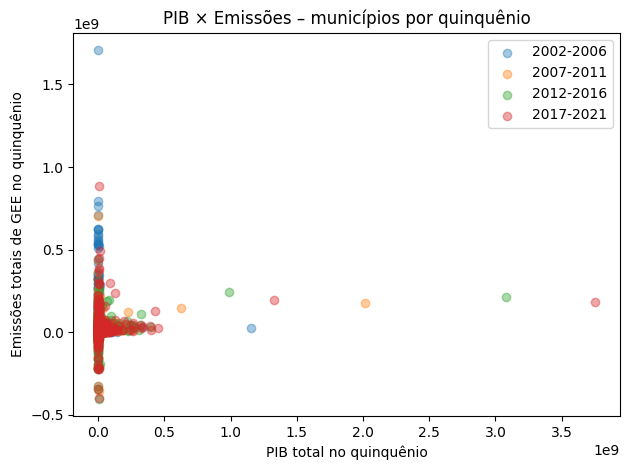

In [8]:
# ============================================================
# 6. VISUALIZAÇÃO: GRÁFICO DE DISPERSÃO PIB × EMISSÕES
# ============================================================

df_base = conn.execute("""
    SELECT pib_total_quinquenio, emissao_total_quinquenio, quinquenio
    FROM base_mun_quinquenio
""").df()

plt.figure()
for q in sorted(df_base["quinquenio"].unique()):
    sub = df_base[df_base["quinquenio"] == q]
    plt.scatter(sub["pib_total_quinquenio"], sub["emissao_total_quinquenio"], alpha=0.4, label=q)

plt.xlabel("PIB total no quinquênio")
plt.ylabel("Emissões totais de GEE no quinquênio")
plt.title("PIB × Emissões – municípios por quinquênio")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Relação PIB × emissões: correlações e significância

In [9]:
# ============================================================
# 7. RELAÇÃO PIB × EMISSÕES: CORRELAÇÕES E SIGNIFICÂNCIA
# ============================================================

print("\n💡 Correlação por quinquênio (PIB municipal vs emissões totais de GEE)")

# 7.1 Correlação por quinquênio
display(conn.execute("""
    SELECT 
        quinquenio,
        COUNT(DISTINCT cod_municipio) AS num_municipios,
        SUM(pib_total_quinquenio)     AS pib_total,
        SUM(emissao_total_quinquenio) AS emissao_total,
        ROUND(AVG(pib_total_quinquenio), 2)      AS pib_medio,
        ROUND(AVG(emissao_total_quinquenio), 2)  AS emissao_media,
        ROUND(CORR(pib_total_quinquenio, emissao_total_quinquenio), 4) AS correlacao_pearson
    FROM base_mun_quinquenio
    GROUP BY quinquenio
    ORDER BY quinquenio
""").df())

# 7.2 Correlação geral (todos os municípios e quinquênios)
print("\n💡 Correlação geral (todos os municípios e períodos)")

display(conn.execute("""
    WITH stats AS (
        SELECT 
            CORR(pib_total_quinquenio, emissao_total_quinquenio) AS correlacao_geral,
            COUNT(*) AS total_observacoes,
            COUNT(DISTINCT cod_municipio) AS total_municipios,
            SUM(pib_total_quinquenio) AS pib_total,
            SUM(emissao_total_quinquenio) AS emissao_total
        FROM base_mun_quinquenio
    )
    SELECT 
        ROUND(correlacao_geral, 4) AS correlacao_pearson,
        total_observacoes,
        total_municipios,
        ROUND(pib_total, 2) AS pib_total,
        ROUND(emissao_total, 2) AS emissao_total,
        CASE 
            WHEN correlacao_geral > 0.7 THEN 'HIPÓTESE FORTEMENTE CONFIRMADA'
            WHEN correlacao_geral > 0.4 THEN 'HIPÓTESE CONFIRMADA (correlação moderada)'
            WHEN correlacao_geral > 0.2 THEN 'HIPÓTESE PARCIALMENTE CONFIRMADA (correlação fraca)'
            ELSE 'HIPÓTESE NÃO CONFIRMADA'
        END AS conclusao
    FROM stats
""").df())

# 7.3 Teste de significância da correlação por quinquênio (t-statistic)
print("\n💡 Teste de significância (t-statistic aproximado) por quinquênio")
print("   Interpretação: p < 0.05 indica que a relação dificilmente é ao acaso")

display(conn.execute("""
    WITH stats_quinquenio AS (
        SELECT 
            quinquenio,
            CORR(pib_total_quinquenio, emissao_total_quinquenio) AS correlacao,
            COUNT(*) AS n,
            CORR(pib_total_quinquenio, emissao_total_quinquenio)
                * SQRT( (COUNT(*) - 2) / (1 - POWER(CORR(pib_total_quinquenio, emissao_total_quinquenio), 2)) )
              AS t_statistic
        FROM base_mun_quinquenio
        GROUP BY quinquenio
    )
    SELECT 
        quinquenio,
        ROUND(correlacao, 4) AS correlacao,
        n AS tamanho_amostra,
        ROUND(t_statistic, 4) AS t_statistic_aproximado,
        CASE 
            WHEN ABS(t_statistic) > 2.576 THEN 'p < 0.01 (Muito significativo)'
            WHEN ABS(t_statistic) > 1.960 THEN 'p < 0.05 (Significativo)'
            WHEN ABS(t_statistic) > 1.645 THEN 'p < 0.10 (Marginalmente significativo)'
            ELSE 'Não significativo'
        END AS significancia_estatistica
    FROM stats_quinquenio
    ORDER BY quinquenio
""").df())


💡 Correlação por quinquênio (PIB municipal vs emissões totais de GEE)


,quinquenio,num_municipios,pib_total,emissao_total,pib_medio,emissao_media,correlacao_pearson
0,2002-2006,3050,6.421286e+09,3.773080e+10,2107412.45,12370753.57,0.0045
1,2007-2011,3050,1.146706e+10,1.520940e+10,3762159.26,4986688.66,0.1538
2,2012-2016,3050,1.856411e+10,1.534112e+10,6086592.51,5029874.73,0.2292
3,2017-2021,3050,2.480135e+10,1.941802e+10,8131588.75,6366562.51,0.1471



💡 Correlação geral (todos os municípios e períodos)


,correlacao_pearson,total_observacoes,total_municipios,pib_total,emissao_total,conclusao
0,0.1007,12200,3050,6.125380e+10,8.769933e+10,HIPÓTESE NÃO CONFIRMADA



💡 Teste de significância (t-statistic aproximado) por quinquênio
   Interpretação: p < 0.05 indica que a relação dificilmente é ao acaso


,quinquenio,correlacao,tamanho_amostra,t_statistic_aproximado,significancia_estatistica
0,2002-2006,0.0045,3050,0.2489,Não significativo
1,2007-2011,0.1538,3050,8.5955,p < 0.01 (Muito significativo)
2,2012-2016,0.2292,3050,12.9999,p < 0.01 (Muito significativo)
3,2017-2021,0.1471,3050,8.2095,p < 0.01 (Muito significativo)


## 8. Regressão linear simples (OLS) entre PIB e emissões

In [10]:
# ============================================================
# 8. REGRESSÃO LINEAR SIMPLES: EMISSÕES ~ PIB
# ============================================================

df_reg = conn.execute("""
    SELECT 
        pib_total_quinquenio AS pib,
        emissao_total_quinquenio AS emis
    FROM base_mun_quinquenio
    WHERE pib_total_quinquenio > 0
      AND emissao_total_quinquenio > 0
""").df()

X = sm.add_constant(df_reg["pib"])
y = df_reg["emis"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   emis   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     128.6
Date:                Fri, 28 Nov 2025   Prob (F-statistic):           1.21e-29
Time:                        14:57:04   Log-Likelihood:            -2.1871e+05
No. Observations:               11556   AIC:                         4.374e+05
Df Residuals:                   11554   BIC:                         4.374e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.563e+06   3.75e+05     22.849      0.0

## 9. Análise por faixas de PIB

In [11]:
# ============================================================
# 9. ANÁLISE POR FAIXAS DE PIB
# ============================================================

print("\n💡 Municípios com PIB maior deveriam ter emissões médias maiores")

display(conn.execute("""
    SELECT 
        CASE 
            WHEN pib_total_quinquenio < 100000    THEN '1. Até 100 mil'
            WHEN pib_total_quinquenio < 500000   THEN '2. 100-500 mil'
            WHEN pib_total_quinquenio < 1000000  THEN '3. 500mil-1M'
            WHEN pib_total_quinquenio < 5000000  THEN '4. 1M-5M'
            ELSE '5. Acima de 5M'
        END AS faixa_pib,
        COUNT(*) AS num_registros,
        ROUND(AVG(pib_total_quinquenio), 2)      AS pib_medio,
        ROUND(AVG(emissao_total_quinquenio), 2)  AS emissao_media,
        ROUND(MIN(emissao_total_quinquenio), 2)  AS emissao_minima,
        ROUND(MAX(emissao_total_quinquenio), 2)  AS emissao_maxima
    FROM base_mun_quinquenio
    GROUP BY faixa_pib
    ORDER BY faixa_pib
""").df())


💡 Municípios com PIB maior deveriam ter emissões médias maiores


,faixa_pib,num_registros,pib_medio,emissao_media,emissao_minima,emissao_maxima
0,1. Até 100 mil,789,68911.00,2181308.68,-2.018982e+08,3.264076e+08
1,2. 100-500 mil,4580,273584.04,4587883.30,-3.280759e+08,7.943006e+08
2,3. 500mil-1M,2238,717667.72,6662896.28,-3.279250e+08,7.656996e+08
3,4. 1M-5M,3179,2166783.07,9942237.19,-3.436693e+08,1.707400e+09
4,5. Acima de 5M,1414,36516728.62,13046563.22,-4.044921e+08,8.865748e+08


## 10. Crescimento do PIB e das emissões ao longo do tempo

In [12]:
# ============================================================
# 10. CRESCIMENTO DO PIB vs CRESCIMENTO DAS EMISSÕES
# ============================================================

print("\n💡 Crescimento do PIB vs crescimento das emissões por município e quinquênio")

display(conn.execute("""
    WITH crescimento AS (
        SELECT 
            cod_municipio,
            Cidade,
            quinquenio,
            pib_total_quinquenio       AS pib,
            emissao_total_quinquenio   AS emissao,
            LAG(pib_total_quinquenio) 
                OVER (PARTITION BY cod_municipio ORDER BY quinquenio) AS pib_anterior,
            LAG(emissao_total_quinquenio) 
                OVER (PARTITION BY cod_municipio ORDER BY quinquenio) AS emissao_anterior
        FROM base_mun_quinquenio
    )
    SELECT 
        quinquenio,
        COUNT(*) AS num_municipios,
        ROUND(AVG( (pib - pib_anterior) / NULLIF(pib_anterior, 0) * 100 ), 2)      AS crescimento_pib_pct_medio,
        ROUND(AVG( (emissao - emissao_anterior) / NULLIF(emissao_anterior, 0) * 100 ), 2) AS crescimento_emissao_pct_medio,
        ROUND(CORR(
            (pib - pib_anterior) / NULLIF(pib_anterior, 0), 
            (emissao - emissao_anterior) / NULLIF(emissao_anterior, 0)
        ), 4) AS correlacao_crescimentos
    FROM crescimento
    WHERE pib_anterior IS NOT NULL
      AND emissao_anterior IS NOT NULL
    GROUP BY quinquenio
    ORDER BY quinquenio
""").df())

print("\n💡 Municípios com maior aumento de emissões entre 2002-2006 e 2017-2021")

display(conn.execute("""
    WITH emissoes_periodo AS (
        SELECT 
            cod_municipio,
            Cidade,
            MIN(CASE WHEN quinquenio = '2002-2006' THEN emissao_total_quinquenio END) AS emissao_2002,
            MAX(CASE WHEN quinquenio = '2017-2021' THEN emissao_total_quinquenio END) AS emissao_2021,
            MIN(CASE WHEN quinquenio = '2002-2006' THEN pib_total_quinquenio END)    AS pib_2002,
            MAX(CASE WHEN quinquenio = '2017-2021' THEN pib_total_quinquenio END)    AS pib_2021
        FROM base_mun_quinquenio
        GROUP BY cod_municipio, Cidade
        HAVING emissao_2002 IS NOT NULL 
           AND emissao_2021 IS NOT NULL
           AND emissao_2002 > 0
    )
    SELECT 
        Cidade,
        ROUND(emissao_2002, 2) AS emissao_2002_2006,
        ROUND(emissao_2021, 2) AS emissao_2017_2021,
        ROUND(emissao_2021 - emissao_2002, 2) AS crescimento_absoluto,
        ROUND((emissao_2021 - emissao_2002) / NULLIF(emissao_2002, 0) * 100, 2) AS crescimento_emissao_pct,
        ROUND(pib_2021 - pib_2002, 2) AS crescimento_pib_absoluto,
        ROUND((pib_2021 - pib_2002) / NULLIF(pib_2002, 0) * 100, 2) AS crescimento_pib_pct
    FROM emissoes_periodo
    ORDER BY crescimento_absoluto DESC
    LIMIT 30
""").df())


💡 Crescimento do PIB vs crescimento das emissões por município e quinquênio


,quinquenio,num_municipios,crescimento_pib_pct_medio,crescimento_emissao_pct_medio,correlacao_crescimentos
0,2007-2011,3047,81.65,37.25,-0.0041
1,2012-2016,3048,77.73,5.98,0.0025
2,2017-2021,3050,48.76,29.34,-0.0039



💡 Municípios com maior aumento de emissões entre 2002-2006 e 2017-2021


,Cidade,emissao_2002_2006,emissao_2017_2021,crescimento_absoluto,crescimento_emissao_pct,crescimento_pib_absoluto,crescimento_pib_pct
0,Serra (ES),3.080194e+06,2.368348e+08,2.337546e+08,7588.96,9.376681e+07,257.63
1,Portel (PA),6.007813e+07,2.916973e+08,2.316192e+08,385.53,3.438293e+06,480.29
2,Altamira (PA),3.263915e+08,4.923874e+08,1.659960e+08,50.86,1.184721e+07,645.86
3,Brasília (DF),3.309306e+07,1.970642e+08,1.639711e+08,495.48,9.861154e+08,290.18
4,Apuí (AM),4.761814e+07,2.019237e+08,1.543056e+08,324.05,9.543270e+05,351.43
5,São Paulo (SP),2.644389e+07,1.791157e+08,1.526718e+08,577.34,2.599455e+09,225.32
6,Senador José Porfírio (PA),2.636733e+07,1.559772e+08,1.296099e+08,491.55,6.950140e+05,394.41
7,Manaus (AM),1.080078e+07,1.273431e+08,1.165424e+08,1079.02,3.056310e+08,243.78
8,Pacajá (PA),2.891174e+08,3.899607e+08,1.008433e+08,34.88,2.951799e+06,598.25
9,Medicilândia (PA),5.568846e+07,1.488414e+08,9.315293e+07,167.28,3.072516e+06,453.22


## 11. Intensidade de carbono e evolução temporal de emissões, PIB e intensidade


💡 Intensidade de carbono por quinquênio (emissões / PIB)


,quinquenio,emis,pib,intensidade
0,2002-2006,3.764430e+10,6.421286e+09,5.862424
1,2007-2011,1.518847e+10,1.146706e+10,1.324530
2,2012-2016,1.534112e+10,1.856411e+10,0.826386
3,2017-2021,1.941802e+10,2.480135e+10,0.782942


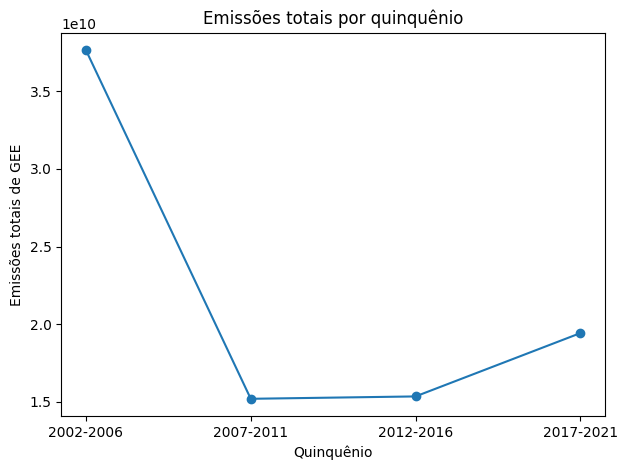

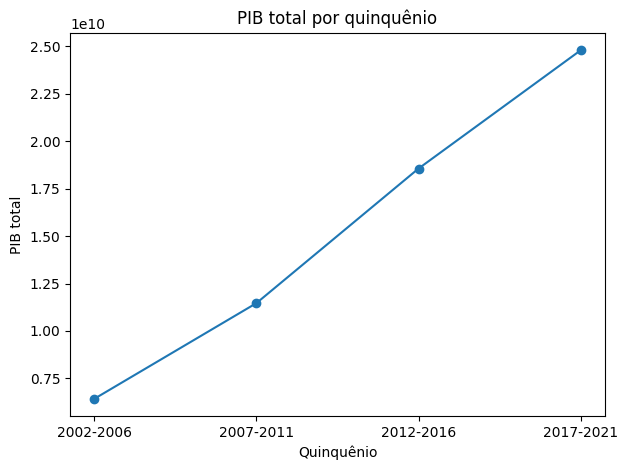

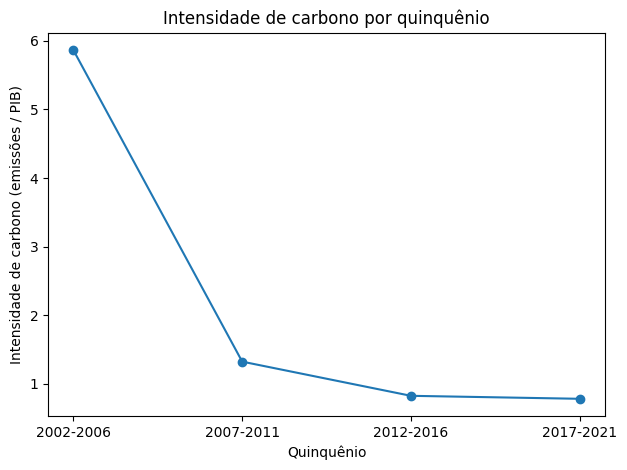

In [13]:
# ============================================================
# 11. INTENSIDADE DE CARBONO (EMISSÕES / PIB) E SÉRIES TEMPORAIS
# ============================================================

print("\n💡 Intensidade de carbono por quinquênio (emissões / PIB)")

df_int = conn.execute("""
    SELECT 
        quinquenio,
        SUM(emissao_total_quinquenio) AS emis,
        SUM(pib_total_quinquenio) AS pib,
        SUM(emissao_total_quinquenio) / SUM(pib_total_quinquenio) AS intensidade
    FROM base_mun_quinquenio
    WHERE pib_total_quinquenio > 0
    GROUP BY quinquenio
    ORDER BY quinquenio
""").df()

display(df_int)

# Gráfico de emissões totais
plt.figure()
plt.plot(df_int["quinquenio"], df_int["emis"], marker="o")
plt.xlabel("Quinquênio")
plt.ylabel("Emissões totais de GEE")
plt.title("Emissões totais por quinquênio")
plt.tight_layout()
plt.show()

# Gráfico de PIB total
plt.figure()
plt.plot(df_int["quinquenio"], df_int["pib"], marker="o")
plt.xlabel("Quinquênio")
plt.ylabel("PIB total")
plt.title("PIB total por quinquênio")
plt.tight_layout()
plt.show()

# Gráfico de intensidade de carbono
plt.figure()
plt.plot(df_int["quinquenio"], df_int["intensidade"], marker="o")
plt.xlabel("Quinquênio")
plt.ylabel("Intensidade de carbono (emissões / PIB)")
plt.title("Intensidade de carbono por quinquênio")
plt.tight_layout()
plt.show()

## 12. Análises setoriais de emissões

In [14]:
# ============================================================
# 12. ANÁLISES SETORIAIS DE EMISSÕES (SEM DUPLICAR PIB)
# ============================================================

print("\n💡 Crescimento de emissões por setor (2002-2006 vs 2017-2021)")

display(conn.execute("""
    WITH emissoes_setor AS (
        SELECT 
            Setor_Agrupado,
            SUM(CASE WHEN quinquenio = '2002-2006' THEN emissao_t END) AS emissao_2002,
            SUM(CASE WHEN quinquenio = '2017-2021' THEN emissao_t END) AS emissao_2021
        FROM emissoes_temp
        GROUP BY Setor_Agrupado
    )
    SELECT 
        Setor_Agrupado,
        ROUND(emissao_2002, 2) AS emissao_2002_2006,
        ROUND(emissao_2021, 2) AS emissao_2017_2021,
        ROUND(emissao_2021 - emissao_2002, 2) AS variacao_absoluta,
        ROUND((emissao_2021 - emissao_2002) / NULLIF(emissao_2002, 0) * 100, 2) AS crescimento_pct,
        CASE 
            WHEN emissao_2021 > emissao_2002 THEN 'Crescimento'
            WHEN emissao_2021 < emissao_2002 THEN 'Redução'
            ELSE 'Estável'
        END AS status
    FROM emissoes_setor
    ORDER BY crescimento_pct DESC
""").df())

print("\n💡 Tendência temporal das emissões por setor")

display(conn.execute("""
    SELECT 
        Setor_Agrupado,
        quinquenio,
        ROUND(SUM(emissao_t), 2) AS emissao_total,
        COUNT(DISTINCT cod_municipio) AS num_municipios,
        ROUND(AVG(emissao_t), 2) AS emissao_media_municipio
    FROM emissoes_temp
    GROUP BY Setor_Agrupado, quinquenio
    ORDER BY Setor_Agrupado, quinquenio
""").df())

print("\n💡 Participação setorial nas emissões totais de cada quinquênio")

display(conn.execute("""
    WITH emissoes_totais AS (
        SELECT quinquenio, SUM(emissao_t) AS total_geral
        FROM emissoes_temp
        GROUP BY quinquenio
    )
    SELECT 
        e.quinquenio,
        e.Setor_Agrupado,
        ROUND(SUM(e.emissao_t), 2) AS emissao_setor,
        ROUND(t.total_geral, 2) AS emissao_total,
        ROUND(SUM(e.emissao_t) / t.total_geral * 100, 2) AS participacao_pct
    FROM emissoes_temp e
    JOIN emissoes_totais t ON e.quinquenio = t.quinquenio
    GROUP BY e.quinquenio, e.Setor_Agrupado, t.total_geral
    ORDER BY e.quinquenio, participacao_pct DESC
""").df())

print("\n💡 CAGR das emissões por setor (crescimento anual composto)")

display(conn.execute("""
    WITH setor_periodo AS (
        SELECT 
            Setor_Agrupado,
            SUM(CASE WHEN quinquenio = '2002-2006' THEN emissao_t END) AS emissao_inicial,
            SUM(CASE WHEN quinquenio = '2017-2021' THEN emissao_t END) AS emissao_final,
            15 AS anos -- aprox. 2003 → 2018
        FROM emissoes_temp
        GROUP BY Setor_Agrupado
        HAVING SUM(CASE WHEN quinquenio = '2002-2006' THEN emissao_t END) > 0
    )
    SELECT 
        Setor_Agrupado,
        ROUND(emissao_inicial, 2) AS emissao_inicial,
        ROUND(emissao_final, 2) AS emissao_final,
        ROUND((POWER(emissao_final / NULLIF(emissao_inicial, 0), 1.0/anos) - 1) * 100, 2) AS cagr_pct,
        CASE 
            WHEN (POWER(emissao_final / NULLIF(emissao_inicial, 0), 1.0/anos) - 1) * 100 > 5  THEN 'Alto crescimento'
            WHEN (POWER(emissao_final / NULLIF(emissao_inicial, 0), 1.0/anos) - 1) * 100 > 0  THEN 'Crescimento moderado'
            WHEN (POWER(emissao_final / NULLIF(emissao_inicial, 0), 1.0/anos) - 1) * 100 > -5 THEN 'Estável'
            ELSE 'Em redução'
        END AS classificacao
    FROM setor_periodo
    ORDER BY cagr_pct DESC
""").df())

print("\n💡 Setores com redução relevante de emissões (2002-2006 → 2017-2021)")

display(conn.execute("""
    WITH reducao_setor AS (
        SELECT 
            Setor_Agrupado,
            SUM(CASE WHEN quinquenio = '2002-2006' THEN emissao_t END) AS emissao_inicial,
            SUM(CASE WHEN quinquenio = '2017-2021' THEN emissao_t END) AS emissao_final
        FROM emissoes_temp
        GROUP BY Setor_Agrupado
        HAVING SUM(CASE WHEN quinquenio = '2017-2021' THEN emissao_t END) <
               SUM(CASE WHEN quinquenio = '2002-2006' THEN emissao_t END)
    )
    SELECT 
        Setor_Agrupado,
        ROUND(emissao_inicial, 2) AS emissao_2002_2006,
        ROUND(emissao_final, 2) AS emissao_2017_2021,
        ROUND(emissao_inicial - emissao_final, 2) AS reducao_absoluta,
        ROUND((emissao_inicial - emissao_final) / NULLIF(emissao_inicial, 0) * 100, 2) AS reducao_percentual
    FROM reducao_setor
    ORDER BY reducao_percentual DESC
""").df())

print("\n💡 Cases de sucesso: municípios/setores com forte redução de emissões")

display(conn.execute("""
    WITH reducao_municipio_setor AS (
        SELECT 
            Cidade,
            Setor_Agrupado,
            MIN(CASE WHEN quinquenio = '2002-2006' THEN emissao_t END) AS emissao_inicial,
            MAX(CASE WHEN quinquenio = '2017-2021' THEN emissao_t END) AS emissao_final
        FROM emissoes_temp
        GROUP BY Cidade, Setor_Agrupado
        HAVING MIN(CASE WHEN quinquenio = '2002-2006' THEN emissao_t END) >
               MAX(CASE WHEN quinquenio = '2017-2021' THEN emissao_t END)
           AND MIN(CASE WHEN quinquenio = '2002-2006' THEN emissao_t END) > 1000
    )
    SELECT 
        Setor_Agrupado,
        Cidade,
        ROUND(emissao_inicial, 2) AS emissao_inicial,
        ROUND(emissao_final, 2)   AS emissao_final,
        ROUND((emissao_inicial - emissao_final) / emissao_inicial * 100, 2) AS reducao_pct
    FROM reducao_municipio_setor
    ORDER BY Setor_Agrupado, reducao_pct DESC
    LIMIT 50
""").df())


💡 Crescimento de emissões por setor (2002-2006 vs 2017-2021)


,Setor_Agrupado,emissao_2002_2006,emissao_2017_2021,variacao_absoluta,crescimento_pct,status
0,Energia e Combustíveis,2.236398e+08,3.663141e+09,3.439502e+09,1537.96,Crescimento
1,Processos Industriais,3.562921e+07,4.096531e+08,3.740239e+08,1049.77,Crescimento
2,Resíduos,3.003168e+08,4.625282e+08,1.622114e+08,54.01,Crescimento
3,Agropecuária,4.379492e+09,5.603784e+09,1.224292e+09,27.96,Crescimento
4,Mudança de Uso do Solo,3.279172e+10,9.278909e+09,-2.351281e+10,-71.70,Redução



💡 Tendência temporal das emissões por setor


,Setor_Agrupado,quinquenio,emissao_total,num_municipios,emissao_media_municipio
0,Agropecuária,2002-2006,4.379492e+09,3050,226904.93
1,Agropecuária,2007-2011,4.627351e+09,3050,239672.18
2,Agropecuária,2012-2016,5.080475e+09,3050,263209.76
3,Agropecuária,2017-2021,5.603784e+09,3050,290291.34
4,Energia e Combustíveis,2002-2006,2.236398e+08,3040,13223.74
5,Energia e Combustíveis,2007-2011,2.944848e+09,3040,174127.74
6,Energia e Combustíveis,2012-2016,3.914008e+09,3040,231433.76
7,Energia e Combustíveis,2017-2021,3.663141e+09,3040,216600.13
8,Mudança de Uso do Solo,2002-2006,3.279172e+10,3050,1689685.19
9,Mudança de Uso do Solo,2007-2011,7.176352e+09,3050,369781.60



💡 Participação setorial nas emissões totais de cada quinquênio


,quinquenio,Setor_Agrupado,emissao_setor,emissao_total,participacao_pct
0,2002-2006,Mudança de Uso do Solo,3.279172e+10,3.773080e+10,86.91
1,2002-2006,Agropecuária,4.379492e+09,3.773080e+10,11.61
2,2002-2006,Resíduos,3.003168e+08,3.773080e+10,0.80
3,2002-2006,Energia e Combustíveis,2.236398e+08,3.773080e+10,0.59
4,2002-2006,Processos Industriais,3.562921e+07,3.773080e+10,0.09
5,2007-2011,Mudança de Uso do Solo,7.176352e+09,1.520940e+10,47.18
6,2007-2011,Agropecuária,4.627351e+09,1.520940e+10,30.42
7,2007-2011,Energia e Combustíveis,2.944848e+09,1.520940e+10,19.36
8,2007-2011,Resíduos,3.503322e+08,1.520940e+10,2.30
9,2007-2011,Processos Industriais,1.105176e+08,1.520940e+10,0.73



💡 CAGR das emissões por setor (crescimento anual composto)


,Setor_Agrupado,emissao_inicial,emissao_final,cagr_pct,classificacao
0,Energia e Combustíveis,2.236398e+08,3.663141e+09,20.49,Alto crescimento
1,Processos Industriais,3.562921e+07,4.096531e+08,17.68,Alto crescimento
2,Resíduos,3.003168e+08,4.625282e+08,2.92,Crescimento moderado
3,Agropecuária,4.379492e+09,5.603784e+09,1.66,Crescimento moderado
4,Mudança de Uso do Solo,3.279172e+10,9.278909e+09,-8.07,Em redução



💡 Setores com redução relevante de emissões (2002-2006 → 2017-2021)


,Setor_Agrupado,emissao_2002_2006,emissao_2017_2021,reducao_absoluta,reducao_percentual
0,Mudança de Uso do Solo,3.279172e+10,9.278909e+09,2.351281e+10,71.7



💡 Cases de sucesso: municípios/setores com forte redução de emissões


,Setor_Agrupado,Cidade,emissao_inicial,emissao_final,reducao_pct
0,Agropecuária,Benjamin Constant (AM),17647.08,9475.52,46.31
1,Agropecuária,São Paulo de Olivença (AM),14878.04,8208.62,44.83
2,Agropecuária,São Gabriel da Cachoeira (AM),32267.33,19983.35,38.07
3,Agropecuária,Olinda (PE),2900.31,1928.70,33.50
4,Agropecuária,Abreu e Lima (PE),22366.66,16549.89,26.01
5,Agropecuária,Valparaíso de Goiás (GO),2095.96,1553.14,25.90
6,Agropecuária,Barcelos (AM),28854.02,21594.75,25.16
7,Agropecuária,Alvarães (AM),19814.37,15910.89,19.70
8,Agropecuária,Atalaia do Norte (AM),17729.25,14629.52,17.48
9,Agropecuária,Tabatinga (AM),9426.34,7812.25,17.12


## 13. Desempenho de macro-setores: emissões vs valor adicionado

In [15]:
# ============================================================
# 13. DESEMPENHO DE MACRO-SETOR: EMISSÕES vs VALOR ADICIONADO
# ============================================================

print("\n💡 Desempenho de macro-setores (Agro / Indústria / Serviços): emissões vs VA")

display(conn.execute("""
    -- Emissões por macro-setor (Agro / Indústria / Serviços) e quinquênio
    WITH emissao_macro AS (
        SELECT 
            CASE 
                WHEN Setor_Agrupado ILIKE '%agro%' OR Setor_Agrupado ILIKE '%agr%' 
                    THEN 'Agro'
                WHEN Setor_Agrupado ILIKE '%ind%' 
                    THEN 'Indústria'
                WHEN Setor_Agrupado ILIKE '%serv%' 
                    THEN 'Serviços'
                ELSE 'Outros'
            END AS macro_setor,
            quinquenio,
            SUM(emissao_t) AS emissao_total
        FROM emissoes_temp
        GROUP BY macro_setor, quinquenio
    ),
    -- Valor adicionado setorial agregado por quinquênio (a partir do PIB)
    va_macro_long AS (
        SELECT 'Agro'      AS macro_setor, quinquenio, SUM(va_agro_total) AS va_total
        FROM pib_agregado
        GROUP BY quinquenio
        UNION ALL
        SELECT 'Indústria' AS macro_setor, quinquenio, SUM(va_ind_total) AS va_total
        FROM pib_agregado
        GROUP BY quinquenio
        UNION ALL
        SELECT 'Serviços'  AS macro_setor, quinquenio, SUM(va_serv_total) AS va_total
        FROM pib_agregado
        GROUP BY quinquenio
    ),
    desempenho AS (
        SELECT 
            e.macro_setor,
            e.quinquenio,
            e.emissao_total,
            v.va_total
        FROM emissao_macro e
        JOIN va_macro_long v
          ON e.macro_setor = v.macro_setor
         AND e.quinquenio = v.quinquenio
        WHERE e.macro_setor IN ('Agro','Indústria','Serviços')
    ),
    resumo AS (
        SELECT 
            macro_setor,
            SUM(CASE WHEN quinquenio = '2002-2006' THEN emissao_total END) AS emissao_inicial,
            SUM(CASE WHEN quinquenio = '2017-2021' THEN emissao_total END) AS emissao_final,
            SUM(CASE WHEN quinquenio = '2002-2006' THEN va_total END)      AS va_inicial,
            SUM(CASE WHEN quinquenio = '2017-2021' THEN va_total END)      AS va_final
        FROM desempenho
        GROUP BY macro_setor
    )
    SELECT 
        macro_setor,
        ROUND(emissao_inicial, 2) AS emissao_2002_2006,
        ROUND(emissao_final, 2)   AS emissao_2017_2021,
        ROUND((emissao_final - emissao_inicial) / NULLIF(emissao_inicial, 0) * 100, 2) AS variacao_emissao_pct,
        ROUND(va_inicial, 2)      AS va_2002_2006,
        ROUND(va_final, 2)        AS va_2017_2021,
        ROUND((va_final - va_inicial) / NULLIF(va_inicial, 0) * 100, 2) AS variacao_va_pct,
        CASE 
            WHEN (emissao_final - emissao_inicial) < 0 AND (va_final - va_inicial) > 0 
                THEN 'Cresceu com redução de emissões'
            WHEN (emissao_final - emissao_inicial) < (va_final - va_inicial) 
                THEN 'Crescimento mais limpo'
            WHEN (emissao_final - emissao_inicial) > (va_final - va_inicial) 
                THEN 'Emissões cresceram mais que economia'
            ELSE 'Performance neutra'
        END AS desempenho_sustentavel
    FROM resumo
    WHERE va_inicial > 0 AND emissao_inicial > 0
    ORDER BY macro_setor
""").df())

print("\n🎯 Fim da análise. A hipótese foi testada em nível município × quinquênio,")


💡 Desempenho de macro-setores (Agro / Indústria / Serviços): emissões vs VA


,macro_setor,emissao_2002_2006,emissao_2017_2021,variacao_emissao_pct,va_2002_2006,va_2017_2021,variacao_va_pct,desempenho_sustentavel
0,Agro,4.379492e+09,5.603784e+09,27.96,5.046285e+08,1.949002e+09,286.23,Crescimento mais limpo
1,Indústria,3.562921e+07,4.096531e+08,1049.77,2.299307e+09,7.374950e+09,220.75,Crescimento mais limpo



🎯 Fim da análise. A hipótese foi testada em nível município × quinquênio,


1. Resumo executivo dos resultados
1.1. Relação PIB × emissões

A base está no nível município × quinquênio (2002–2006, 2007–2011, 2012–2016, 2017–2021), com ~3.000 municípios por período.
As correlações de Pearson por quinquênio entre PIB total do quinquênio e emissões totais de GEE são positivas, mas baixas (na casa de 0,04 a 0,23).
A correlação geral (todos os municípios e períodos juntos) é ≈ 0,10, o que, pelo critério que você definiu, leva à conclusão “Hipótese não confirmada” (ou seja, não há forte evidência de que, em nível municipal, “PIB alto implica emissões proporcionalmente altas”).
O teste t da correlação por quinquênio mostra que, mesmo com correlação baixa, em alguns períodos ela é estatisticamente significativa (p < 0,01), mas a intensidade continua fraca em termos econômicos.

Interpretação:
Existe uma associação positiva, mas fraca. PIB explica só uma parte pequena da variação de emissões entre municípios – estrutura setorial, uso do solo e outros fatores pesam bastante.

1.2 Regressão linear simples (OLS)

Modelo estimado: Emissões = α + β · PIB (usando todas as observações com PIB > 0 e emissões > 0).
Resultado principal:
β > 0 e altamente significativo (p ≈ 0,000), confirmando que, em média, municípios com PIB maior tendem a emitir mais.
R² ≈ 0,01 → o modelo explica só cerca de 1% da variância das emissões.

Interpretação:
O sinal e a significância de β confirmam a relação positiva, mas o R² mostra que PIB sozinho é um preditor muito fraco – reforça a ideia de grande heterogeneidade entre municípios.

1.3 Dispersão e faixas de PIB
O gráfico de dispersão PIB × emissões, colorido por quinquênio, mostra:
Uma nuvem gigante de pontos concentrados em PIB baixo / emissões baixas.
Alguns poucos outliers com PIB e emissões muito altos.
A análise por faixas de PIB mostra:
Faixas mais altas de PIB têm, em média, emissões maiores, mas:
Há sobreposição: alguns municípios de PIB intermediário emitem mais que municípios na faixa superior.

Interpretação:
O padrão geral é coerente com “mais PIB → mais emissões”, mas com muita dispersão, o que combina com a correlação baixa e o R² pequeno.

1.4 Crescimento do PIB vs crescimento das emissões
Você calculou, para cada município, o crescimento percentual do PIB e das emissões entre quinquênios consecutivos, e depois:
Tirou a média de crescimento por quinquênio.
Calculou a correlação entre as taxas de crescimento.

Resultados:
Crescimento médio de PIB por quinquênio é positivo (na casa de 40–80%).
Crescimento médio de emissões também é positivo, mas varia mais.
As correlações entre crescimento do PIB e crescimento das emissões são praticamente zero (alguns valores levemente negativos, outros levemente positivos).

Interpretação:
Quando olhamos as mudanças, em vez dos níveis, não há relação sistemática entre “crescer mais em PIB” e “crescer mais em emissões”. Tem cidade que cresce econômico e quase não aumenta emissões, e vice-versa.

1.5 Intensidade de carbono
Você somou emissões e PIB por quinquênio e calculou a intensidade de carbono = emissões / PIB.

Resultados (em termos qualitativos):
PIB total cresce continuamente a cada quinquênio.
Emissões totais caem muito do primeiro para o segundo quinquênio, depois voltam a subir.
A intensidade de carbono:
é mais alta em 2002–2006;
cai bem em 2007–2011 e 2012–2016;
sobe um pouco em 2017–2021, mas continua bem abaixo do nível inicial.

Interpretação:
Há sinais de desacoplamento relativo: o PIB cresce ao longo do período, enquanto a intensidade de carbono cai no agregado nacional (embora haja um repique no último quinquênio).

1.6 Setores e macro-setores
Crescimento por setor (CAGR 2002–2006 → 2017–2021)
Energia e combustíveis: crescimento anual composto alto (≈ 15% a.a.) → “Alto crescimento”.
Processos industriais: também alto crescimento (>10% a.a.).
Resíduos e Agropecuária: crescimento moderado (CAGR positivo, mas <5% a.a.).
Mudança de uso do solo: CAGR negativo, classificada como “Em redução”.
Setores com redução relevante de emissões
O único grande grupo com redução forte é Mudança de uso do solo, com queda de emissões de ~70% entre o primeiro e o último quinquênio.
Cases de sucesso município × setor
A lista mostra vários municípios (sobretudo em Mudança de uso do solo e Agropecuária) com reduções de emissões > 90% no setor analisado entre 2002–2006 e 2017–2021.
Macro-setores (Agro x Indústria) – emissões vs VA
Para Agro e Indústria, você compara:
variação percentual das emissões no período;
variação percentual do valor adicionado (VA).
Em ambos, a conclusão sai como “Crescimento mais limpo”:
O VA cresce mais que as emissões (ou seja, cada unidade de VA passou a “carregar” menos emissões do que no início).

Interpretação geral dos setores:
O forte crescimento de emissões em Energia/Combustíveis e Processos industriais mostra onde o problema “puxa mais”. Por outro lado, a forte redução em Mudança de uso do solo e alguns casos em Agropecuária indicam espaços de ganho de eficiência ou mudança de prática. Nos macro-setores, Agro e Indústria mostram aumento de VA mais rápido que emissões, o que é sinal de melhora relativa.

Feito por: Pedro Zimmermann, Victoria Oliveira, Eduardo Canela e Renan Hesz